In [12]:
import crypten
import torch
import numpy as np
import matplotlib.pyplot as plt
import crypten.mpc as mpc

import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent parent dir
sys.path.append("../helpers/")
sys.path.append("../helpers/utils")
sys.path.append("../helpers/mpc")
import utils
import sparse_linreg_damgard

import time

crypten.init()

torch.set_num_threads(1)
torch.set_printoptions(precision=32) # default

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/anaconda3/envs/mpc/lib/python3.7/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [13]:
def compute_noise_scale(s, eta, n):
    # set constants
    c0 = 1
    cx = 1
    R = 1

    # compute B and lambda
    # B can be larger than this, but the smallest scale had B equal to this
    B = 4 * (R + cx * c0) * (cx / np.sqrt(s))
    lmb = eta * (B / n)
    return B, lmb

In [14]:
order = 3
d = 500
T = 100
eta = 0.1
n = 1
k = 50
result = {}

for noise_type in ['no_noise', 'noise_output', 'noise_output_and_per_it']: 
    data = utils.sample_dataset(n * (10 ** order), d, 0.05, k, 1)
    _, lmb = compute_noise_scale(k, eta, n * (10 ** order))

    it_err, last_err = sparse_linreg_damgard.solve(data, (lmb, 1, 0.9, noise_type), k, T, a=64, c=0, eta=0.1, eps=0.001)
    result[noise_type] = it_err
    print('done')

0
10
20
30
40
50
60
70
80
90
done
0
10
20
30
40
50
60
70
80
90
done
0
10
20
30
40
50
60
70
80
90
done


In [235]:
print(it_err_no_noise)

[0.967514486889491, 0.9361118617600657, 0.9057314152189754, 0.8763399015467752, 0.8479301203789905, 0.8204369702533932, 0.7938420133067972, 0.7681322629347105, 0.7432663264217405, 0.7192112456326838, 0.6959410671587104, 0.6734308517319458, 0.6516579252922803, 0.6306074543478439, 0.6102389988945545, 0.5905455385435572, 0.5714829725863713, 0.5530391820667824, 0.535207111442767, 0.5179560318734363, 0.5012663182269266, 0.4851211277729717, 0.4695118405432951, 0.4543990745675175, 0.43978943708961343, 0.42565710123491546, 0.41198163736968635, 0.3987469823494586, 0.3859445406706744, 0.373548708077828, 0.3615688380393945, 0.3499749525567899, 0.33875059055604084, 0.32789934193558185, 0.3173956572119773, 0.3072389575927993, 0.29739305341447986, 0.28787113758221866, 0.27865893495476673, 0.26973945220643236, 0.2611283907250459, 0.25278521209655663, 0.24471258646486244, 0.23689878233033865, 0.2293451614095834, 0.22204498240606665, 0.21496645995037822, 0.2081176060340727, 0.20149890812029284, 0.19508

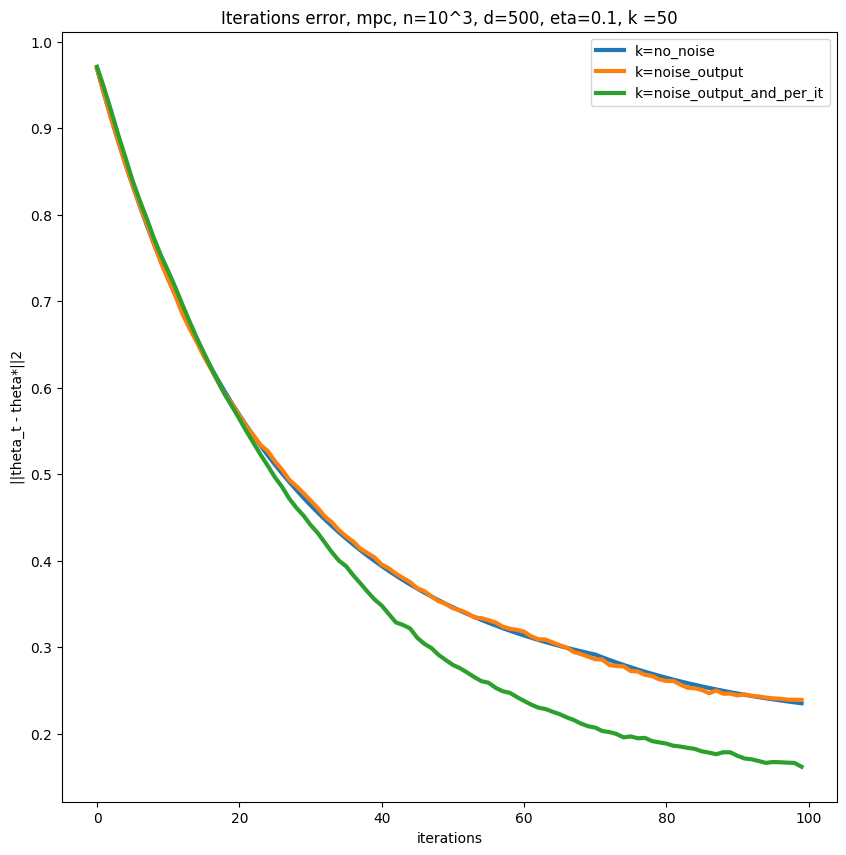

In [11]:
utils.plot_error_by_iteration_and_dict_key(
    result,
    title=f'Iterations error, mpc, n={n}0^{order}, d={d}, eta={eta}, k ={k}',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="k")

In [258]:
import json

with open('100it_no_noise.txt', 'w') as filehandle:
    json.dump(result['no_noise'], filehandle)